In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Financials 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data.drop(columns=['purchasing power of the consumer dollar','other personal services'],axis=1,inplace=True)
data = data.dropna()
data

,date,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),S&P 500 Financials (Sector) Outperform/Underperform,overall,commodities,other services,housing,shelter,services
0,1993-05-04,444.05,99.760002,-1.150884,-1.169011,-1.1690112706754352,144.300,131.300,176.600,141.200,155.800,157.8
1,1993-05-05,444.52,99.500000,-0.275939,-0.748130,UNDERPERFORM,144.300,131.300,176.600,141.200,155.800,157.8
2,1993-05-06,443.26,99.190002,-0.621034,-0.321576,OUTPERFORM,144.300,131.300,176.600,141.200,155.800,157.8
3,1993-05-07,442.31,99.129997,-1.117793,-1.235435,UNDERPERFORM,144.300,131.300,176.600,141.200,155.800,157.8
4,1993-05-10,442.80,99.660004,-0.979471,-0.489264,OUTPERFORM,144.300,131.300,176.600,141.200,155.800,157.8
...,...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,1656.619995,4.852728,14.000423,OUTPERFORM,280.126,210.452,380.688,288.259,341.963,348.1
7195,2021-11-26,4594.62,1612.869995,1.616263,9.348602,OUTPERFORM,280.126,210.452,380.688,288.259,341.963,348.1
7196,2021-11-29,4655.27,1639.089966,1.484354,9.904247,OUTPERFORM,280.126,210.452,380.688,288.259,341.963,348.1
7197,2021-11-30,4567.00,1615.829956,1.396956,10.303088,OUTPERFORM,280.126,210.452,380.688,288.259,341.963,348.1


## Using all data (Best Model)

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),S&P 500 Financials (Sector) Outperform/Underperform,overall,commodities,other services,housing,shelter,services,dow
0,1993,5,1993-05-13,439.23,99.300003,-2.195551,-1.556459,OUTPERFORM,144.300,131.300,176.600,141.200,155.800,157.800,3
1,1993,6,1993-06-10,445.38,100.440002,-2.363206,-2.475965,UNDERPERFORM,144.500,131.300,177.100,141.300,155.900,158.100,3
2,1993,7,1993-07-08,448.64,99.639999,-2.220866,-3.299691,UNDERPERFORM,144.800,131.600,177.800,141.700,156.200,158.600,3
3,1993,8,1993-08-12,448.96,102.529999,-3.088911,-6.185380,UNDERPERFORM,145.000,131.300,178.900,142.000,156.500,159.000,3
4,1993,9,1993-09-09,457.50,102.480003,-1.320047,-9.741059,UNDERPERFORM,145.600,132.200,179.700,142.300,156.900,159.400,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,1462.900024,-2.530346,-0.461997,OUTPERFORM,273.092,201.975,377.425,281.979,335.888,342.831,3
339,2021,8,2021-08-12,4460.83,1448.939941,-1.849766,-4.989416,UNDERPERFORM,274.214,203.215,378.584,283.532,337.298,343.808,3
340,2021,9,2021-09-09,4493.28,1470.270020,-4.490556,-11.834229,UNDERPERFORM,276.590,206.035,380.322,285.453,338.865,345.648,3
341,2021,10,2021-10-14,4438.26,1476.890015,-7.366228,-8.690219,UNDERPERFORM,278.524,208.467,380.061,286.849,340.475,346.911,3


In [4]:
original = data[['S&P 500 Financials (Sector) Outperform/Underperform','month','overall','commodities',\
                 'other services','housing','shelter','services']]

In [5]:
data.drop(columns=['date','S&P 500 Financials (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),overall,commodities,other services,housing,shelter,services,dow
0,5,439.23,99.300003,-2.195551,-1.556459,144.3,131.3,176.6,141.2,155.8,157.8,3
1,6,445.38,100.440002,-2.363206,-2.475965,144.5,131.3,177.1,141.3,155.9,158.1,3
2,7,448.64,99.639999,-2.220866,-3.299691,144.8,131.6,177.8,141.7,156.2,158.6,3
3,8,448.96,102.529999,-3.088911,-6.185380,145.0,131.3,178.9,142.0,156.5,159.0,3
4,9,457.50,102.480003,-1.320047,-9.741059,145.6,132.2,179.7,142.3,156.9,159.4,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Financials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities',\
                 'other services','housing','shelter','services']]

In [7]:
dd.data_summary(original)

,Info
Rows,343
Columns,8
Size in Memory,21.6 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.47,0.50,2,181
month,int64,0,0,1,7,12,6.53,3.44,12,29
overall,float64,0,0,144.30,208.55,280.13,205.34,36.44,328,3
commodities,float64,0,0,131.30,167.20,210.45,165.28,19.54,291,4
other services,float64,0,0,176.60,287.23,380.69,283.13,58.59,341,2
housing,float64,0,0,141.20,210.50,288.26,205.75,39.72,337,2
shelter,float64,0,0,155.80,242.037,341.96,238.0078,50.65,336,2
services,float64,0,0,157.80,248.25,348.10,245.092,53.60,343,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

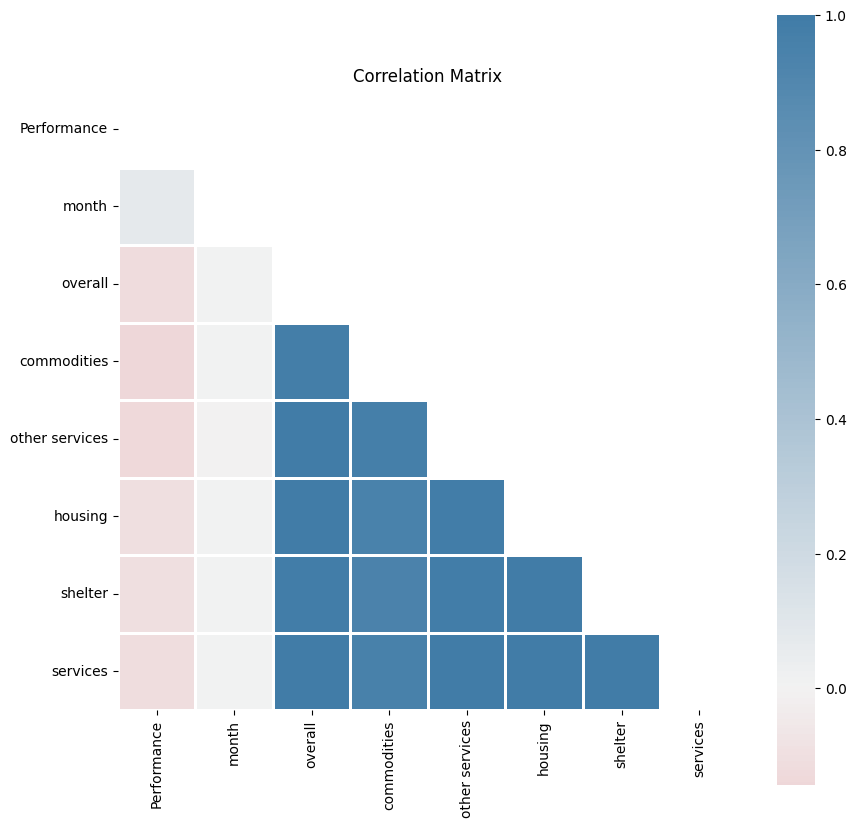

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),overall,commodities,other services,housing,shelter,services,dow
0,2,1310.054784,233.183123,-4.821998,-8.946729,167.136079,142.835722,265.035846,208.237192,248.244500,241.424435,3
1,1,1369.164154,300.094167,-2.349076,-3.766657,255.857341,178.437954,288.780691,250.628316,243.612300,272.523109,3
2,9,716.547241,123.411479,-3.205200,-0.287645,142.365883,142.053132,182.266549,148.329268,149.552375,150.880967,3
3,7,1508.021942,315.437700,3.348018,15.564172,221.787372,146.931473,311.093223,237.537199,254.408558,172.297130,3
4,10,608.400413,201.906176,10.642203,2.707932,213.631704,160.922703,241.804986,173.570646,228.303181,213.178761,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,12,1231.448146,288.824823,-4.339793,-13.011121,239.062816,186.511649,302.563983,206.332996,267.894033,273.497273,3
9996,10,358.350045,127.144013,-3.053447,-4.256245,165.332596,136.180715,171.376629,137.461876,174.410289,166.738305,3
9997,1,1261.861316,257.889437,-4.360901,-4.894079,248.892782,171.862418,318.944978,229.056000,242.953049,266.366383,3
9998,11,927.506310,128.879439,2.609954,9.396716,153.269120,139.015889,174.645126,171.671256,179.126356,161.610085,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Financials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','commodities',\
                 'other services','housing','shelter','services']]
samples.head()

,Performance,month,overall,commodities,other services,housing,shelter,services
0,0,2,167.136079,142.835722,265.035846,208.237192,248.244500,241.424435
1,0,1,255.857341,178.437954,288.780691,250.628316,243.612300,272.523109
2,1,9,142.365883,142.053132,182.266549,148.329268,149.552375,150.880967
3,1,7,221.787372,146.931473,311.093223,237.537199,254.408558,172.297130
4,0,10,213.631704,160.922703,241.804986,173.570646,228.303181,213.178761


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,8
Size in Memory,625.1 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.37,0.48,2,6323
month,int64,0,0,1,7,12,6.60,3.43,12,893
overall,float64,0,0,134.012,216.50,310.91,207.91,40.11,10000,1
commodities,float64,0,0,121.38,171.24,231.95,165.75,20.074,10000,1
other services,float64,0,0,144.14,280.86,411.79,273.99,65.26,10000,1
housing,float64,0,0,127.0078,206.87,317.56,203.69,38.30,9999,2
shelter,float64,0,0,137.27,237.90,364.34,234.58,48.61,10000,1
services,float64,0,0,128.47,246.80,368.67,238.59,53.00,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

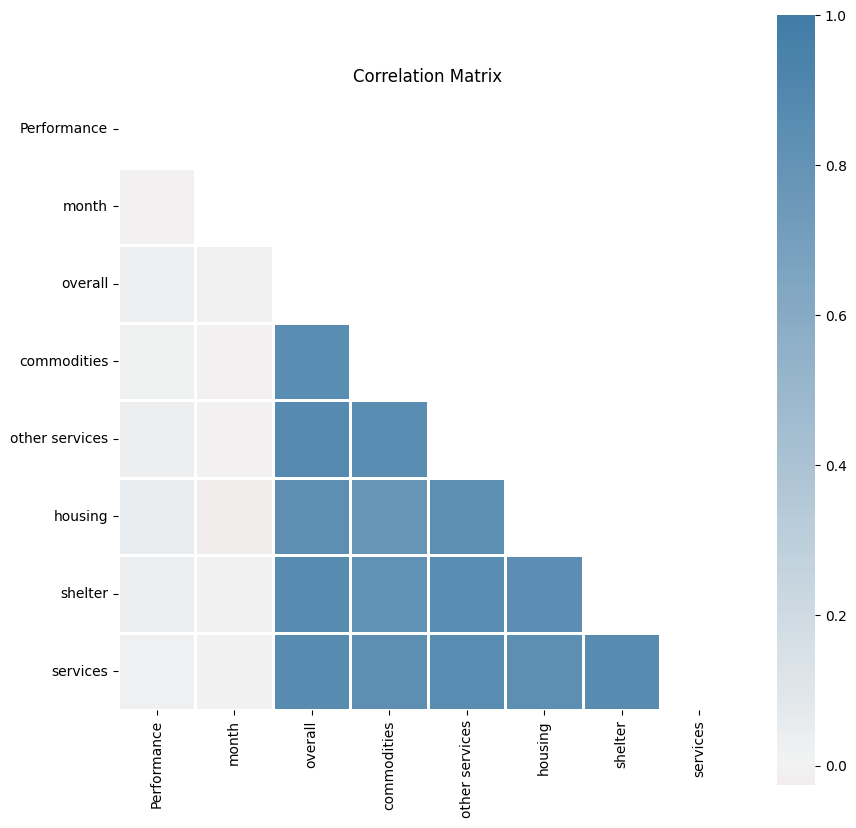

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 6323, 1: 3677})
Counter({0: 6323, 1: 6323})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  167.13607937,   142.83572215,   265.03584553, ...,
        51693.73750279, 50273.54626127, 59932.28811258],
       [  255.85734099,   178.43795389,   288.78069139, ...,
        61056.14058203, 68302.00801094, 66389.98140431],
       [  142.36588279,   142.05313216,   182.26654863, ...,
        22182.99430142, 22380.06346317, 22564.60701253],
       ...,
       [  174.37698461,   149.11819918,   208.73696939, ...,
        29199.23804829, 30188.01690795, 30908.75107227],
       [  153.99658741,   137.55727577,   176.34610779, ...,
        25714.48850324, 26761.49095166, 30862.81661905],
       [  170.73103504,   144.95129504,   182.93299561, ...,
        29554.12049356, 36908.28112268, 43801.0754722 ]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(12646, 22)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(343, 22)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.62029,0.603706,0.69147,0.643883,0.615117,0.601266,0.666029,0.631993,0.498542,0.47449,0.574074,0.519553
1,DecisionTreeClassifier,0.613092,0.604452,0.645286,0.623405,0.589184,0.58113,0.616316,0.598206,0.54519,0.52027,0.475309,0.496774
2,RandomForestClassifier,0.722151,0.712265,0.733883,0.718327,0.706831,0.702396,0.710006,0.706181,0.527697,0.5,0.487654,0.49375
3,AdaBoostClassifier,0.578763,0.586587,0.534404,0.559192,0.592347,0.596154,0.553219,0.573884,0.54519,0.516484,0.580247,0.546512
4,GradientBoostingClassifier,0.59869,0.607034,0.560026,0.582408,0.611322,0.611549,0.594009,0.602651,0.562682,0.535714,0.555556,0.545455
5,ExtraTreesClassifier,0.749672,0.745537,0.748284,0.741479,0.734978,0.737184,0.724028,0.730547,0.51312,0.481752,0.407407,0.441472
6,BaggingClassifier,0.674544,0.684962,0.634871,0.656183,0.655281,0.669498,0.602932,0.634474,0.521866,0.493243,0.450617,0.470968
7,SVC,0.552511,0.561831,0.476524,0.515562,0.561037,0.563066,0.514978,0.537949,0.55102,0.520833,0.617284,0.564972
8,GaussianNB,0.525543,0.544735,0.311091,0.395888,0.535104,0.555932,0.313576,0.400978,0.489796,0.441441,0.302469,0.358974


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.710626,0.698905,0.732314,0.715219


## Using data after 2000

In [22]:
data = pd.read_csv('../data/S&P 500 Financials 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data.drop(columns=['purchasing power of the consumer dollar','other personal services'],axis=1,inplace=True)
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),S&P 500 Financials (Sector) Outperform/Underperform,overall,commodities,other services,housing,shelter,services,dow
80,2000,1,2000-01-13,1449.68,298.109985,-4.867901,4.504653,OUTPERFORM,170.000,147.600,227.200,167.300,190.900,192.500,3
81,2000,2,2000-02-10,1416.83,280.170013,-0.911278,-1.164140,UNDERPERFORM,171.000,149.100,227.700,167.700,191.600,193.100,3
82,2000,3,2000-03-09,1401.69,255.740005,-0.373858,-6.360068,UNDERPERFORM,170.900,148.500,228.100,167.900,191.900,193.500,3
83,2000,4,2000-04-13,1440.51,286.480011,-1.016965,12.098925,OUTPERFORM,171.200,148.500,228.700,168.300,192.400,194.000,3
84,2000,5,2000-05-11,1407.81,272.510010,-3.857159,2.282032,OUTPERFORM,172.200,149.600,229.200,169.200,193.100,194.900,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,1462.900024,-2.530346,-0.461997,OUTPERFORM,273.092,201.975,377.425,281.979,335.888,342.831,3
339,2021,8,2021-08-12,4460.83,1448.939941,-1.849766,-4.989416,UNDERPERFORM,274.214,203.215,378.584,283.532,337.298,343.808,3
340,2021,9,2021-09-09,4493.28,1470.270020,-4.490556,-11.834229,UNDERPERFORM,276.590,206.035,380.322,285.453,338.865,345.648,3
341,2021,10,2021-10-14,4438.26,1476.890015,-7.366228,-8.690219,UNDERPERFORM,278.524,208.467,380.061,286.849,340.475,346.911,3


In [23]:
original = data[['S&P 500 Financials (Sector) Outperform/Underperform','month','overall','commodities',\
                 'other services','housing','shelter','services']]
data.drop(columns=['date','S&P 500 Financials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Financials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities',\
                 'other services','housing','shelter','services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),overall,commodities,other services,housing,shelter,services,dow
0,10,1654.616720,509.997470,-8.776536,-6.733189,221.262213,185.455539,341.640947,224.212456,340.195207,266.127757,3
1,12,1162.070872,270.909981,-3.797579,-2.722228,191.292500,155.155675,258.613368,187.347413,221.769172,209.822891,3
2,5,1435.706788,521.695099,-7.110233,-5.590055,251.499919,184.704899,348.728569,264.411692,308.508140,315.871542,3
3,10,1981.329366,238.128894,-7.875540,-4.752652,221.997321,174.569860,352.049937,220.001128,249.061482,254.290967,3
4,6,1310.368850,251.737549,0.025030,3.910408,218.055987,171.477487,277.301081,219.802657,258.689087,271.810820,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,10,1795.615237,253.261120,-0.335631,2.337149,234.995628,183.624826,320.767243,219.436825,242.892389,262.730609,3
9996,1,1703.632956,568.858473,-7.217168,-4.283059,231.298085,183.166905,333.195571,249.475458,311.026127,301.159669,3
9997,4,1082.867423,203.089474,-0.159234,3.332218,183.145166,147.191162,247.102905,175.076654,204.425307,183.865820,3
9998,1,1939.964836,758.640045,-6.156485,-6.897585,256.295448,193.494058,351.258274,261.571991,298.551220,307.125652,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Financials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','commodities',\
                 'other services','housing','shelter','services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.592642,0.603983,0.547787,0.573904,0.577224,0.588915,0.539112,0.562914,0.532319,0.463768,0.566372,0.50996
1,DecisionTreeClassifier,0.57805,0.586497,0.553656,0.568021,0.567972,0.573372,0.564482,0.568892,0.498099,0.440994,0.628319,0.518248
2,RandomForestClassifier,0.647377,0.668408,0.624483,0.64165,0.631317,0.64112,0.613108,0.626801,0.505703,0.440559,0.557522,0.492187
3,AdaBoostClassifier,0.581243,0.592198,0.52233,0.554752,0.57331,0.587025,0.522903,0.553112,0.536122,0.461538,0.477876,0.469565
4,GradientBoostingClassifier,0.591121,0.592357,0.584086,0.588078,0.596085,0.601429,0.593376,0.597375,0.532319,0.464789,0.584071,0.517647
5,ExtraTreesClassifier,0.660726,0.686381,0.642101,0.657359,0.643772,0.654815,0.622974,0.638498,0.524715,0.459459,0.60177,0.521073
6,BaggingClassifier,0.603593,0.635422,0.507744,0.562827,0.598221,0.627193,0.503876,0.558812,0.501901,0.427419,0.469027,0.447257
7,SVC,0.576171,0.592821,0.488518,0.535426,0.57758,0.600694,0.487667,0.538312,0.574144,0.504762,0.469027,0.486239
8,GaussianNB,0.57341,0.591429,0.476595,0.527743,0.575801,0.598268,0.486963,0.536908,0.570342,0.5,0.486726,0.493274


## Using data after 2010

In [25]:
data = pd.read_csv('../data/S&P 500 Financials 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data.drop(columns=['purchasing power of the consumer dollar','other personal services'],axis=1,inplace=True)
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),S&P 500 Financials (Sector) Outperform/Underperform,overall,commodities,other services,housing,shelter,services,dow
200,2010,1,2010-01-14,1148.46,238.649994,-2.110431,-8.440438,UNDERPERFORM,217.281,174.321,307.253,216.042,247.997,259.970,3
201,2010,2,2010-02-11,1078.47,230.320007,-11.020997,-18.683796,UNDERPERFORM,217.353,174.137,307.568,216.146,247.914,260.342,3
202,2010,3,2010-03-11,1150.24,252.570007,5.750719,1.060343,UNDERPERFORM,217.403,173.874,308.675,216.092,247.959,260.672,3
203,2010,4,2010-04-08,1186.44,265.380005,6.168177,3.607398,UNDERPERFORM,217.290,173.367,309.303,216.128,248.128,260.932,3
204,2010,5,2010-05-13,1157.44,264.690002,3.805347,4.964906,OUTPERFORM,217.199,172.929,309.997,216.060,248.295,261.188,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,1462.900024,-2.530346,-0.461997,OUTPERFORM,273.092,201.975,377.425,281.979,335.888,342.831,3
339,2021,8,2021-08-12,4460.83,1448.939941,-1.849766,-4.989416,UNDERPERFORM,274.214,203.215,378.584,283.532,337.298,343.808,3
340,2021,9,2021-09-09,4493.28,1470.270020,-4.490556,-11.834229,UNDERPERFORM,276.590,206.035,380.322,285.453,338.865,345.648,3
341,2021,10,2021-10-14,4438.26,1476.890015,-7.366228,-8.690219,UNDERPERFORM,278.524,208.467,380.061,286.849,340.475,346.911,3


In [26]:
original = data[['S&P 500 Financials (Sector) Outperform/Underperform','month','overall','commodities',\
                 'other services','housing','shelter','services']]
data.drop(columns=['date','S&P 500 Financials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Financials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities',\
                 'other services','housing','shelter','services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),overall,commodities,other services,housing,shelter,services,dow
0,1,2449.266915,549.161764,-1.483070,-2.267864,229.995313,177.445792,334.908217,227.324311,257.518757,264.977384,3
1,7,1593.785277,227.723448,2.439085,0.936549,219.523964,183.859881,310.679800,221.121436,249.819372,255.993170,3
2,7,1289.495912,322.578566,-2.942256,-3.134849,237.295224,180.843406,317.019794,223.032110,270.059558,282.087346,3
3,9,1463.108093,472.298784,-1.132287,-6.051671,231.257019,185.795062,312.772280,228.462145,258.922221,263.902878,3
4,5,1328.822158,263.564834,-3.968558,-5.413663,229.087148,185.588554,317.603899,227.549339,265.605912,274.768830,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,10,1305.765369,324.967051,-9.564191,-23.331292,226.654642,180.877759,318.161460,226.196863,265.371534,282.281630,3
9996,2,991.427200,222.477259,-6.537987,-7.889415,225.095264,183.976538,316.493967,223.930462,262.088125,259.292235,3
9997,2,3372.357226,1102.120878,-5.904107,-4.238228,268.214604,181.101903,370.191041,271.058193,318.764967,336.120551,3
9998,5,1960.578116,591.732035,-2.618406,-3.823024,240.255235,186.864013,335.217535,258.050332,312.929489,275.169043,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Financials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','commodities',\
                 'other services','housing','shelter','services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.664967,0.641821,0.739561,0.686603,0.64884,0.626053,0.724496,0.671687,0.531469,0.42029,0.517857,0.464
1,DecisionTreeClassifier,0.639111,0.627882,0.672875,0.64826,0.626611,0.618306,0.645224,0.631479,0.538462,0.413793,0.428571,0.421053
2,RandomForestClassifier,0.734317,0.719386,0.760838,0.736942,0.706508,0.691697,0.736192,0.713251,0.601399,0.492063,0.553571,0.521008
3,AdaBoostClassifier,0.6333,0.627505,0.655932,0.641354,0.627577,0.615292,0.664068,0.63875,0.622378,0.513889,0.660714,0.578125
4,GradientBoostingClassifier,0.644336,0.634381,0.680587,0.656557,0.634021,0.618182,0.68486,0.649815,0.629371,0.518987,0.732143,0.607407
5,ExtraTreesClassifier,0.76122,0.745581,0.786135,0.761799,0.732925,0.718596,0.758285,0.737907,0.58042,0.458333,0.392857,0.423077
6,BaggingClassifier,0.693643,0.703387,0.660803,0.679035,0.676546,0.686932,0.638726,0.661953,0.531469,0.403509,0.410714,0.40708
7,SVC,0.625567,0.625491,0.625491,0.625286,0.625966,0.620382,0.632878,0.626568,0.643357,0.533333,0.714286,0.610687
8,GaussianNB,0.600516,0.618175,0.526258,0.568458,0.605348,0.618223,0.533463,0.572724,0.601399,0.490566,0.464286,0.477064
